In [1]:
import sys
#!{sys.executable} -m pip install openpyxl

In [2]:
#!{sys.executable} -m pip install category_encoders

In [3]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping

%matplotlib inline

import openpyxl

In [4]:
dfFao = pd.read_csv("FAOSTAT.csv")
dfCountries = pd.read_csv("iso-country-codes.csv")
dfConsumption = pd.read_csv("oecd_meat_consumption.csv")

dfFao.head(2)

,Domain Code,Domain,Area Code (FAO),Area,Element Code,Element,Item Code (FAO),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1961,1961,tonnes,43000.0,F,FAO estimate
1,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1962,1962,tonnes,45800.0,F,FAO estimate


In [5]:
dfCountries.head(2)

,English short name lower case,Alpha-2 code,Alpha-3 code,Numeric code,ISO 3166-2
0,Zimbabwe,ZW,ZWE,716,ISO 3166-2:ZW
1,Zambia,ZM,ZMB,894,ISO 3166-2:ZM


In [6]:
dfConsumption.head(2)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1990,0.000,NaN
1,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1991,27.942,NaN


## Pasos para limpiar dfCountries
1. Seleccionar solo aquellas columnas necesarias.
2. Renombrar las columnas al igual que las columnas en los otros dataset para luego hacer los joins.
3. Revisar qué valores de dfCountries no hacen correspondencia con los códigos o nombres usados en los otros datasets.

### Paso 1 y 2

In [7]:
dfCountries = dfCountries[['Alpha-3 code', 'English short name lower case']] \
    .rename(columns={'Alpha-3 code': 'LOCATION', 'English short name lower case':'Area'})
dfCountries.head(5)

,LOCATION,Area
0,ZWE,Zimbabwe
1,ZMB,Zambia
2,YEM,Yemen
3,ESH,Western Sahara
4,WLF,Wallis and Futuna


### Paso 3: emparejado de valores

In [8]:
def unirDf(df1, df2, columna):
    df1 = df1.merge(df2, on=columna, how='left', indicator=True)
    print('valores que no hacen correspondencia:')
    print(df1[df1['_merge'] != 'both'])
    return df1


dfUnicosEnConsumo = pd.DataFrame(dfConsumption['LOCATION'].unique(), columns = ['LOCATION'])
dfJoinedConsumptionAndCountries = unirDf(dfUnicosEnConsumo, dfCountries, 'LOCATION')

valores que no hacen correspondencia:
   LOCATION Area     _merge
32      WLD  NaN  left_only
33     OECD  NaN  left_only
34    BRICS  NaN  left_only


Esto es esperado, pues el dataset de consumo de OEDC usa esos tres valores para poner valores especiales para su propio análisis.

Ahora, quitamos esos valores y revisamos cuáles valores no están en el dataset de producción de FAO.

In [9]:
dfConsumptionOK = dfJoinedConsumptionAndCountries[dfJoinedConsumptionAndCountries['_merge'] == 'both'][['Area']]

def corroborarValoresEnFAO(df):
    dfUnicosEnFao = pd.DataFrame(dfFao['Area'].unique(), columns = ['Area'])
    _ = unirDf(df, dfUnicosEnFao, 'Area')
    
corroborarValoresEnFAO(dfConsumptionOK)

valores que no hacen correspondencia:
              Area     _merge
3      South Korea  left_only
6           Turkey  left_only
7    United States  left_only
17            Iran  left_only
26          Russia  left_only
31         Vietnam  left_only
34  United Kingdom  left_only


Correcciones a valores en dfFao

In [10]:
def corregirValorEnFao(malo, bueno, columma='Area'):
    dfFao.loc[dfFao[columma] == malo, columma] = bueno

corregirValorEnFao('Republic of Korea', 'South Korea')
corregirValorEnFao('United States of America', 'United States')
corregirValorEnFao('Iran (Islamic Republic of)', 'Iran')
corregirValorEnFao('Russian Federation', 'Russia')
corregirValorEnFao('Viet Nam', 'Vietnam')
corregirValorEnFao('United Kingdom of Great Britain and Northern Ireland', 'United Kingdom')
corregirValorEnFao('Türkiye', 'Turkey')

corroborarValoresEnFAO(dfConsumptionOK)

valores que no hacen correspondencia:
Empty DataFrame
Columns: [Area, _merge]
Index: []


In [11]:
dfCountries.head(5)

,LOCATION,Area
0,ZWE,Zimbabwe
1,ZMB,Zambia
2,YEM,Yemen
3,ESH,Western Sahara
4,WLF,Wallis and Futuna


----

## Pasos para limpiar dfConsumption
Pasos:
1. Unir los datos de Consumo con los países.
2. Quitar los códigos de 'Location' propios del análisis de la OECD.
3. Remover entradas para Turquía.
4. Quitar columnas innecesarias.

### 1. Unir datos con dataframe de países

In [12]:
dfConsumption = dfConsumption.merge(dfCountries, on='LOCATION', how='left', indicator=True)
dfConsumption.head(5)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes,Area,_merge
0,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1990,0.000,NaN,Australia,both
1,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1991,27.942,NaN,Australia,both
2,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1992,26.405,NaN,Australia,both
3,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1993,26.370,NaN,Australia,both
4,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1994,25.662,NaN,Australia,both


In [13]:
dfConsumption[dfConsumption['_merge'] != 'both']['LOCATION'].unique()

array(['WLD', 'OECD', 'BRICS'], dtype=object)

### 2. Remover Location extras

Remover filas cuando el 'Location' es 'WLD', 'OECD' o 'BRICS'.

Esos son valores totales usados por OECD para comparaciones que no son necesarios para nuestro análisis.

In [14]:
dfConsumption = dfConsumption[dfConsumption['_merge'] == 'both']
dfConsumption.head(3)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes,Area,_merge
0,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1990,0.000,NaN,Australia,both
1,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1991,27.942,NaN,Australia,both
2,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1992,26.405,NaN,Australia,both


### 3. Columnas innecesarias
Descubriendo cuáles columnas son innecesarias:
- Location (se sustituye por Area).
- Flag Codes que son solo nulos.
- Frecuencia: que siempre es A de Anual.
- Indicador: que siempre es MEATCONSUMP.
- Columnas de códigos redundantes como Year Code, Item Code, Element Code, Area Code
- Measure: solo vamos a ocupar por toneladas, no kg/cápita, pues el dataset de FAO solo tiene toneladas

In [15]:
dfConsumption['Flag Codes'].unique()

array([nan])

In [16]:
dfConsumption['FREQUENCY'].unique()

array(['A'], dtype=object)

In [17]:
dfConsumption['INDICATOR'].unique()

array(['MEATCONSUMP'], dtype=object)

En FAO solo tenemos tonnes, mientras que en OECD tenemos tonnes y kg/cápita

In [18]:
dfConsumption['MEASURE'].unique()

array(['KG_CAP', 'THND_TONNE'], dtype=object)

In [19]:
dfFao['Unit'].unique()

array(['tonnes'], dtype=object)

In [20]:
dfConsumption = dfConsumption[dfConsumption['MEASURE']== 'THND_TONNE']
dfConsumption.head(3)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes,Area,_merge
5600,KOR,MEATCONSUMP,SHEEP,THND_TONNE,A,1990,9.563,NaN,South Korea,both
5601,KOR,MEATCONSUMP,SHEEP,THND_TONNE,A,1991,7.896,NaN,South Korea,both
5602,KOR,MEATCONSUMP,SHEEP,THND_TONNE,A,1992,15.467,NaN,South Korea,both


In [21]:
dfConsumption = dfConsumption[['Area', 'SUBJECT', 'TIME', 'Value']]
dfConsumption.head(3)

,Area,SUBJECT,TIME,Value
5600,South Korea,SHEEP,1990,9.563
5601,South Korea,SHEEP,1991,7.896
5602,South Korea,SHEEP,1992,15.467


----

## Pasos para limpiar dfFao
Este dataset contiene datos de la producción total en toneladas.

Para nuestro análisis solo nos interesa la producción, para poder compararla con el consumo (dfConsumption).

In [22]:
dfFao.head(5)

,Domain Code,Domain,Area Code (FAO),Area,Element Code,Element,Item Code (FAO),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1961,1961,tonnes,43000.0,F,FAO estimate
1,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1962,1962,tonnes,45800.0,F,FAO estimate
2,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1963,1963,tonnes,47250.0,F,FAO estimate
3,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1964,1964,tonnes,48000.0,F,FAO estimate
4,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1965,1965,tonnes,48700.0,F,FAO estimate


In [23]:
dfFao['Unit'].unique()

array(['tonnes'], dtype=object)

In [24]:
dfFao['Value'].isnull().sum()

68

In [25]:
dfFao = dfFao[['Area', 'Item', 'Year', 'Value']]
dfFao.head(3)

,Area,Item,Year,Value
0,Afghanistan,"Meat, cattle",1961,43000.0
1,Afghanistan,"Meat, cattle",1962,45800.0
2,Afghanistan,"Meat, cattle",1963,47250.0


In [26]:
dfFao = dfFao[dfFao['Value'] != None]
dfFao.head(3)

,Area,Item,Year,Value
0,Afghanistan,"Meat, cattle",1961,43000.0
1,Afghanistan,"Meat, cattle",1962,45800.0
2,Afghanistan,"Meat, cattle",1963,47250.0


---
---

# Primeros Gráficos

In [27]:
corregirValorEnFao('Meat, cattle', 'BEEF', 'Item')
corregirValorEnFao('Meat, chicken', 'POULTRY', 'Item')
corregirValorEnFao('Meat, sheep', 'SHEEP', 'Item')
corregirValorEnFao('Meat, pig', 'PIG', 'Item')


In [28]:
dfFao['Item'].unique()

array(['BEEF', 'POULTRY', 'SHEEP', 'PIG'], dtype=object)

In [29]:
dfFao.head(3)

,Area,Item,Year,Value
0,Afghanistan,BEEF,1961,43000.0
1,Afghanistan,BEEF,1962,45800.0
2,Afghanistan,BEEF,1963,47250.0


In [30]:
dfConsumption.head(3)

,Area,SUBJECT,TIME,Value
5600,South Korea,SHEEP,1990,9.563
5601,South Korea,SHEEP,1991,7.896
5602,South Korea,SHEEP,1992,15.467


In [31]:
new_df = pd.merge(dfConsumption.rename(columns={'Value': 'Consumption'}), 
                  dfFao.rename(columns={'Value': 'Production'}),
                  how='inner',
                  left_on=['Area','SUBJECT', 'TIME'], right_on = ['Area','Item', 'Year'])
new_df = new_df[['Area', 'Item', 'TIME', 'Consumption', 'Production']]

#cambiar escala de consumo pues está en miles de toneladas
new_df['Consumption'] = new_df['Consumption'] * 1000

new_df.head(10)

,Area,Item,TIME,Consumption,Production
0,South Korea,SHEEP,1990,9563.0,14.0
1,South Korea,SHEEP,1991,7896.0,14.0
2,South Korea,SHEEP,1992,15467.0,29.0
3,South Korea,SHEEP,1993,11516.0,8.0
4,South Korea,SHEEP,1994,14189.0,7.0
5,South Korea,SHEEP,1995,12722.0,7.0
6,South Korea,SHEEP,1996,10887.0,7.0
7,South Korea,SHEEP,1997,9606.0,6.0
8,South Korea,SHEEP,1998,8067.0,5.0
9,South Korea,SHEEP,1999,6814.0,5.0


In [32]:
new_df.describe()

,TIME,Consumption,Production
count,4211.000000,4.211000e+03,4.188000e+03
mean,2005.122536,1.402071e+06,1.340810e+06
std,8.884115,4.367043e+06,4.401340e+06
min,1990.000000,0.000000e+00,0.000000e+00
25%,1997.000000,1.144215e+05,8.312625e+04
50%,2005.000000,3.648420e+05,3.086875e+05
75%,2013.000000,1.037394e+06,9.474450e+05
max,2020.000000,5.870460e+07,5.766187e+07


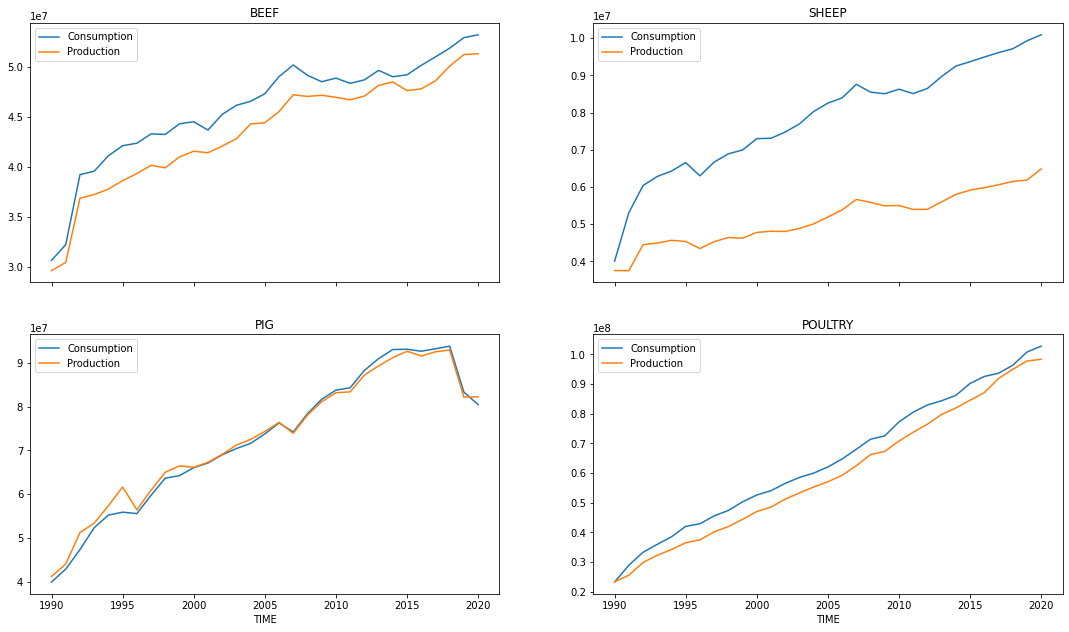

In [33]:
fig, ax = plt.subplots(2, 2, sharex='col')
ejes = ax.flatten()
tipos = ['BEEF', 'SHEEP', 'PIG', 'POULTRY']

fig.set_size_inches(18.5, 10.5)

for i in range(4):
    new_df.where(new_df['Item']==tipos[i]) \
        .groupby('TIME') \
        .sum() \
        .plot(title=tipos[i], ax=ejes[i])
fig.savefig('porTipo.png', dpi=100)

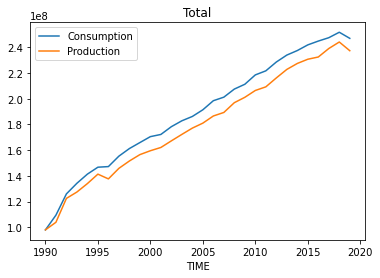

In [34]:
axe = new_df.where(new_df['TIME']<2020).groupby('TIME').sum().plot(title='Total')
axe.get_figure().savefig('total.png', dpi=100)

In [35]:
paises = new_df['Area'].unique()
print(len(paises))
paises

35


array(['South Korea', 'South Africa', 'India', 'Norway', 'Ethiopia',
       'Ukraine', 'Saudi Arabia', 'Russia', 'Thailand', 'Kazakhstan',
       'Israel', 'Egypt', 'United States', 'Nigeria', 'Vietnam',
       'New Zealand', 'Peru', 'Turkey', 'Japan', 'Brazil', 'Indonesia',
       'Argentina', 'Colombia', 'Malaysia', 'Iran', 'Switzerland',
       'Pakistan', 'Canada', 'Chile', 'Philippines', 'Australia', 'China',
       'Mexico', 'Paraguay', 'United Kingdom'], dtype=object)

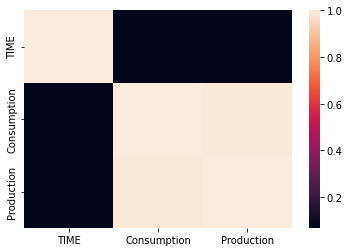

In [36]:
axe = sns.heatmap(new_df.corr())
axe.get_figure().savefig('correlation.png', dpi=100)

In [37]:
new_df.corr()

,TIME,Consumption,Production
TIME,1.000000,0.069150,0.068393
Consumption,0.069150,1.000000,0.991085
Production,0.068393,0.991085,1.000000


In [38]:
new_df.head(3)

,Area,Item,TIME,Consumption,Production
0,South Korea,SHEEP,1990,9563.0,14.0
1,South Korea,SHEEP,1991,7896.0,14.0
2,South Korea,SHEEP,1992,15467.0,29.0


Se crea la columna a 'futuro' para poder hacer el merge utilizando ese valor

In [39]:
new_df["time+1"] = (new_df['TIME']+1)
new_df.head(3)

,Area,Item,TIME,Consumption,Production,time+1
0,South Korea,SHEEP,1990,9563.0,14.0,1991
1,South Korea,SHEEP,1991,7896.0,14.0,1992
2,South Korea,SHEEP,1992,15467.0,29.0,1993


In [40]:
df_for_time2 = pd.merge(left=new_df, right=new_df, how='left', 
         left_on=['Area','Item', 'time+1'], right_on = ['Area','Item', 'TIME'])

df_for_time2 = df_for_time2[['Area','Item', 'TIME_x', 'Consumption_x', 'Production_x', 'Consumption_y','Production_y']]
df_for_time2 = df_for_time2.rename(columns={'TIME_x': 'Time'})
df_for_time2.head(3)

,Area,Item,Time,Consumption_x,Production_x,Consumption_y,Production_y
0,South Korea,SHEEP,1990,9563.0,14.0,7896.0,14.0
1,South Korea,SHEEP,1991,7896.0,14.0,15467.0,29.0
2,South Korea,SHEEP,1992,15467.0,29.0,11516.0,8.0


In [41]:
df_for_time2.tail(3)

,Area,Item,Time,Consumption_x,Production_x,Consumption_y,Production_y
4208,United Kingdom,SHEEP,2018,299124.0,289000.0,302000.0,307000.0
4209,United Kingdom,SHEEP,2019,302000.0,307000.0,302996.0,296000.0
4210,United Kingdom,SHEEP,2020,302996.0,296000.0,NaN,NaN


In [42]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import category_encoders as ce


In [43]:
encoder = ce.OneHotEncoder()
new_df_enc = encoder.fit_transform(df_for_time2)

In [44]:
new_df_enc.columns

Index(['Area_1', 'Area_2', 'Area_3', 'Area_4', 'Area_5', 'Area_6', 'Area_7',
       'Area_8', 'Area_9', 'Area_10', 'Area_11', 'Area_12', 'Area_13',
       'Area_14', 'Area_15', 'Area_16', 'Area_17', 'Area_18', 'Area_19',
       'Area_20', 'Area_21', 'Area_22', 'Area_23', 'Area_24', 'Area_25',
       'Area_26', 'Area_27', 'Area_28', 'Area_29', 'Area_30', 'Area_31',
       'Area_32', 'Area_33', 'Area_34', 'Area_35', 'Item_1', 'Item_2',
       'Item_3', 'Item_4', 'Time', 'Consumption_x', 'Production_x',
       'Consumption_y', 'Production_y'],
      dtype='object')

In [45]:
new_df_enc.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4201, 4202, 4203, 4204, 4205, 4206, 4207, 4208, 4209, 4210],
           dtype='int64', length=4211)

In [46]:
#Dividir en dataframe en datos de entrenamiento y prueba
feature_cols = ['Area_1', 'Area_2', 'Area_3', 'Area_4', 'Area_5', 'Area_6', 'Area_7',
       'Area_8', 'Area_9', 'Area_10', 'Area_11', 'Area_12', 'Area_13',
       'Area_14', 'Area_15', 'Area_16', 'Area_17', 'Area_18', 'Area_19',
       'Area_20', 'Area_21', 'Area_22', 'Area_23', 'Area_24', 'Area_25',
       'Area_26', 'Area_27', 'Area_28', 'Area_29', 'Area_30', 'Area_31',
       'Area_32', 'Area_33', 'Area_34', 'Area_35', 'Item_1', 'Item_2',
       'Item_3', 'Item_4', 'Time', 'Consumption_x']

dfTrainConsumo = new_df_enc[new_df_enc.Time < 2019 ]
dfTestConsumo  = new_df_enc[new_df_enc.Time == 2019]
print('Nulos para consumo:', dfTrainConsumo.Consumption_x.isnull().sum())
print('Nulos para consumo:', dfTestConsumo .Consumption_x.isnull().sum())

dfTrainProd = new_df_enc[(new_df_enc.Time < 2019)  & (new_df_enc.Production_y.notnull()) ]
dfTestProd  = new_df_enc[(new_df_enc.Time == 2019) & (new_df_enc.Production_y.notnull()) ]
print('Nulos para producción:', dfTrainProd.Production_y.isnull().sum())
print('Nulos para producción:', dfTestProd .Production_y.isnull().sum())

Nulos para consumo: 0
Nulos para consumo: 0
Nulos para producción: 0
Nulos para producción: 0


In [47]:
# Dataframes para la predicción real para le año 2021
# En las columnas '_y' quedará el valor de 2021

dfPredConsumo = dfTestConsumo.copy()
dfPredConsumo.Time = 2020
dfPredConsumo.Consumption_x = dfPredConsumo.Consumption_y
dfPredConsumo.Consumption_y = 0
dfPredConsumo.Production_y  = None

dfPredProd = dfTestProd.copy()
dfPredProd.Time = 2020
dfPredProd.Production_x = dfPredConsumo.Production_x
dfPredProd.Consumption_y = None
dfPredProd.Production_y  = 0


In [48]:
def printTotalesConsumo():
    totalRecords = new_df_enc[new_df_enc.Time <= 2019].shape[0]
    print('Datos sobre Consumo')
    print('total de datos iniciales:', new_df_enc.shape[0])
    print('total de datos sin nulos (por el T, T+1):', totalRecords)
    print('datos de entrenamiento:', dfTrainConsumo.shape[0], " = {:.2f}%".format(dfTrainConsumo.shape[0] / totalRecords * 100))
    print('datos de prueba:', dfTestConsumo.shape[0], " = {:.2f}%".format(dfTestConsumo.shape[0] / totalRecords * 100))
printTotalesConsumo()

Datos sobre Consumo
total de datos iniciales: 4211
total de datos sin nulos (por el T, T+1): 4074
datos de entrenamiento: 3937  = 96.64%
datos de prueba: 137  = 3.36%


In [49]:
def printTotalesProduccion():
    totalRecords = new_df_enc[(new_df_enc.Time <= 2019) & (new_df_enc.Production_y.notnull())].shape[0]
    print('Datos sobre Producción')
    print('total de datos iniciales:', new_df_enc.shape[0])
    print('total de datos sin nulos (por el T, T+1) o valores faltantes:', totalRecords)
    print('datos de entrenamiento:', dfTrainProd.shape[0], " = {:.2f}%".format(dfTrainProd.shape[0] / totalRecords * 100))
    print('datos de prueba:', dfTestProd.shape[0], " = {:.2f}%".format(dfTestProd.shape[0] / totalRecords * 100))
printTotalesProduccion()

Datos sobre Producción
total de datos iniciales: 4211
total de datos sin nulos (por el T, T+1) o valores faltantes: 4051
datos de entrenamiento: 3916  = 96.67%
datos de prueba: 135  = 3.33%


### Modelos de análisis

In [50]:
def neural_model(look_back, trainX, trainY, epochs, batch_size, testX, testY):
    model = Sequential()
    model.add(Dense(41, input_dim=look_back, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(testX,testY), 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)],shuffle=False)
    return model, history

In [51]:
def model_loss(history, titulo=''):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Pérdida del modelo RNN' + titulo)
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [52]:
def prediction_plot(realY, predictY, l, leyendaY, titulo):
    len_prediction=[x for x in range(len(realY))]
    plt.figure(figsize=(8,4))
    plt.plot(len_prediction, realY[:l], marker='o', label="actual")
    plt.plot(len_prediction, predictY[:l], '-', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel(leyendaY, size=15)
    plt.xlabel('Entrada', size=15)
    plt.title(titulo)
    plt.legend(fontsize=15)
    plt.show();

In [53]:
def get_mse_r2(values, prediction):
    rmse = np.sqrt(metrics.mean_squared_error(values, prediction))
    r2 = metrics.r2_score(values, prediction)
    return (rmse, r2)

In [54]:
def ejecutarModelos(dfTrain, dfTest, dfPred, featureX, featureY, name):
    # variable para guardar los errores
    global mseResults
    mseResults = mseResults if 'mseResults' in globals() else {}
    mseResults[name] = {}
    
    # variable para guardar predicciones de 2020
    global predicciones2020
    predicciones2020 = predicciones2020 if 'predicciones2020' in globals() else {}
    predicciones2020[name] = {}
    
    # usa columna Consumption_x o Production_x
    feature_cols[len(feature_cols)-1] = featureX
    
    # selección de datos
    X_train = dfTrain[feature_cols]
    Y_train = dfTrain[featureY]

    X_test = dfTest[feature_cols]
    Y_test = dfTest[featureY]
    
    X_pred = dfPred[feature_cols]
    
    # ------------------------------------
    
    # Decision Tree
    clf = DecisionTreeRegressor()
    clf.fit(X_train,Y_train)
    
    Y_pred_train = clf.predict(X_train)
    Y_pred_test  = clf.predict(X_test)
    dfPred[featureY] = clf.predict(X_pred)
    
    # Calculando error
    errorTreeTrain = get_mse_r2(Y_train, Y_pred_train)
    print('DecisionTree . Train Score: %.2f MSE (%.2f R2)' % errorTreeTrain)
    
    errorTreeTest  = get_mse_r2(Y_test, Y_pred_test)
    print('DecisionTree . Test Score: %.2f MSE (%.2f R2)' % errorTreeTest)
    
    mseResults[name]['tree'] = {'train': errorTreeTrain[0], 'test': errorTreeTest[0]}
    predicciones2020[name]['tree'] = Y_pred_test.sum()
    
    prediction_plot(Y_test, Y_pred_test, Y_test.shape[0], name, 'DecisionTree para '+name)
    # ------------------------------------
    
    # Red Neuronal
    model, history = neural_model(X_train.shape[1], X_train, Y_train, 300, 20, X_test, Y_test)

    trainScore = model.evaluate(X_train, Y_train, verbose=0)
    print('Neural network . Train Score: %.2f MSE (%.2f MAE)' % (trainScore[0], trainScore[1]))
    
    testScore = model.evaluate(X_test, Y_test, verbose=0)
    print('Neural network . Test Score: %.2f MSE (%.2f MAE)' % (trainScore[0], trainScore[1]))
    
    mseResults[name]['rnn'] = {'train': trainScore[0], 'test': testScore[0]}
    
    #histórico de pérdida del modelo en cada epoch
    model_loss(history)
    
    # predicciones del modelo de RNN
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    predicciones2020[name]['rnn'] = testPredict.sum()
    
    prediction_plot(Y_test, testPredict, Y_test.shape[0], name, 'RNN para '+name)

DecisionTree . Train Score: 0.00 MSE (1.00 R2)
DecisionTree . Test Score: 283633.81 MSE (1.00 R2)


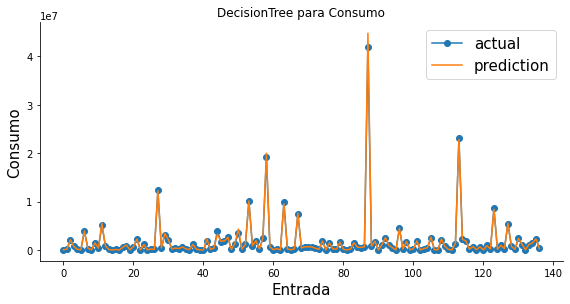

2022-07-28 05:48:16.274767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Neural network . Train Score: 83017449472.00 MSE (63991.89 MAE)
Neural network . Test Score: 83017449472.00 MSE (63991.89 MAE)


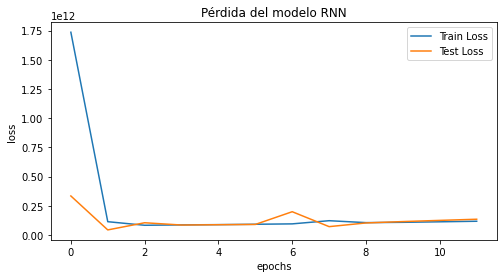

5/5 [==============================] - 0s 1ms/step


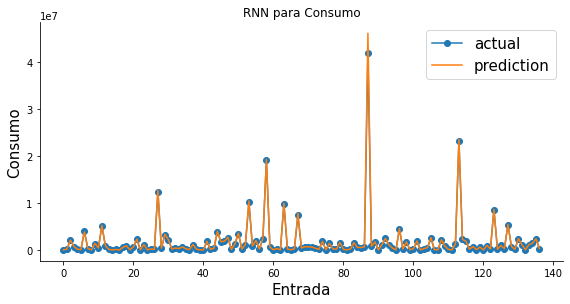

In [55]:
mseResults = {}
predicciones2020 =  {}
ejecutarModelos(dfTrainConsumo, dfTestConsumo, dfPredConsumo, 'Consumption_x', 'Consumption_y', 'Consumo')

DecisionTree . Train Score: 0.00 MSE (1.00 R2)
DecisionTree . Test Score: 756788.85 MSE (0.97 R2)


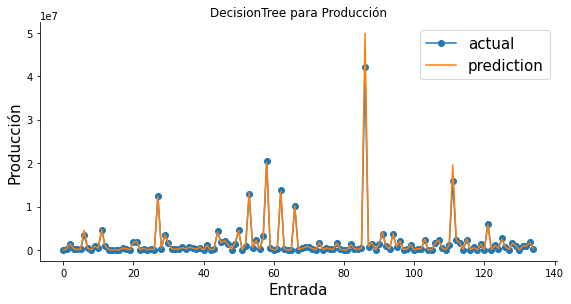

Neural network . Train Score: 350537940992.00 MSE (165780.91 MAE)
Neural network . Test Score: 350537940992.00 MSE (165780.91 MAE)


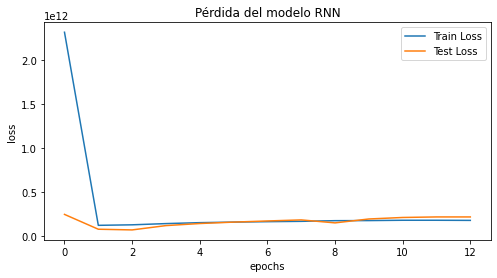

5/5 [==============================] - 0s 1ms/step


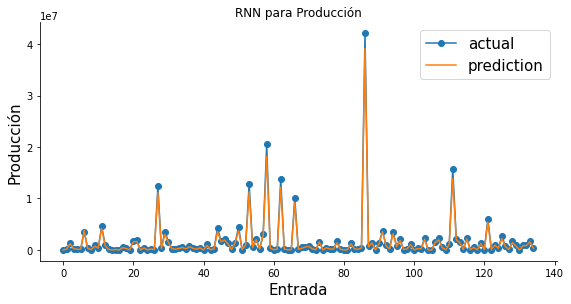

In [56]:
ejecutarModelos(dfTrainProd, dfTestProd, dfPredProd, 'Production_x', 'Production_y', 'Producción')

### Errores de ambos modelos
Los errores se estiman utilizando el MSE (Mean Standard Error).

In [57]:
pd.json_normalize (mseResults)

,Consumo.tree.train,Consumo.tree.test,Consumo.rnn.train,Consumo.rnn.test,Producción.tree.train,Producción.tree.test,Producción.rnn.train,Producción.rnn.test
0,0.0,283633.805995,8.301745e+10,1.354456e+11,0.0,756788.846242,3.505379e+11,2.165467e+11


### Predicciones de ambos modelos
Las predicciones se comparan los datos de prueba de 2020, contra la predicción para 2020

In [58]:
predicciones2020

{'Consumo': {'tree': 252290383.0, 'rnn': 254874020.0},
 'Producción': {'tree': 251465690.0, 'rnn': 214389060.0}}

In [59]:
predicciones2020['Consumo']['Real'] = new_df[new_df.TIME == 2020].Consumption.sum()
predicciones2020['Producción']['Real'] = new_df[new_df.TIME == 2020].Production.sum()
pd.json_normalize (predicciones2020)

,Consumo.tree,Consumo.rnn,Consumo.Real,Producción.tree,Producción.rnn,Producción.Real
0,252290383.0,254874016.0,246539331.0,251465690.0,214389056.0,238388169.0


### Juntando los resultados de ambas predicciones
En un solo dataset para exportarlo y usarlo para construir los gráficos

In [60]:
datosPredichos = df_for_time2.loc[dfPredConsumo.index][['Area', 'Item']]
datosPredichos['TIME'] = 2021
datosPredichos['Consumption'] = dfPredConsumo['Consumption_y']

datosPredichos.loc[dfPredProd.index, 'Production'] = dfPredProd['Production_y']

# se pega al final con los datos originales 
# (luego de mezclados las tres fuentes de datos en new_df)
print(new_df.shape)
print(datosPredichos.shape)

dfParaGraficos = pd.concat([new_df[['Area', 'Item', 'TIME', 'Consumption', 'Production']], datosPredichos])
print(dfParaGraficos.shape)
dfParaGraficos.to_csv('datosConPrediccion2021.csv',index=False)


(4211, 6)
(137, 5)
(4348, 5)


In [61]:
datosPredichos

,Area,Item,TIME,Consumption,Production
29,South Korea,SHEEP,2021,18835.0,6.0
60,South Africa,SHEEP,2021,170900.0,214111.0
91,South Korea,PIG,2021,2098465.0,1424388.0
122,India,SHEEP,2021,711407.0,289000.0
153,Norway,PIG,2021,125860.0,122116.0
...,...,...,...,...,...
4085,Malaysia,SHEEP,2021,38501.0,1880.0
4116,United Kingdom,BEEF,2021,1125594.0,915640.0
4147,United Kingdom,PIG,2021,1450053.0,957000.0
4178,United Kingdom,POULTRY,2021,2299763.0,1677838.0
